In [9]:
import numpy as np
import matplotlib.pyplot as plt
# import scipy.stats
from numpy import log
import ultranest
from ultranest.plot import cornerplot
from scipy.stats import poisson
from scipy.stats import norm
import pandas as pd
import healpy as hp
from healpy.newvisufunc import projview, newprojplot
import astropy.units as u
from numpy import pi, sin
from scipy.interpolate import interp1d
import scipy.stats as stats

In [10]:
def pixel_angles(pixel_vec, dipole_vec):
    dot_product = np.dot(pixel_vec, dipole_vec)
    theta = np.arccos(dot_product) # don't need the magnitude bc they are unit vectors
    return theta

def poisson_sampling(NSIDE, N_bar, D, dipole_theta, dipole_phi):
    NPIX = hp.nside2npix(NSIDE)
    pixel_vec = np.vstack(hp.pix2vec(NSIDE, np.arange(NPIX))).T
    dipole_vec = hp.ang2vec(dipole_theta, dipole_phi) # (x, y, z) from (b, l)
    
    theta_angle = pixel_angles(pixel_vec, dipole_vec)
    lambda_ = N_bar * (1 + D*np.cos(theta_angle))
    sample = np.random.poisson(lambda_)
    return sample, lambda_
        
def plotting(m, dipole_theta=None, dipole_phi=None, title=None, unit=None, cmap='viridis'):
    projview(m, title=title, unit=unit,
    graticule=True, graticule_labels=True, projection_type="mollweide", cmap=cmap);

    newprojplot(theta=dipole_theta, phi=dipole_phi, marker="*", color="k", markersize=15);
    plt.tight_layout()
#     plt.show()
#     plt.close()
    return


def omega_to_theta(omega):
    '''Convert solid angle in steradins to theta in radians for
    a cone section of a sphere. Taken from the code used in Secrest (2021),
    namely in CatWISE_Dipole_Resulys.ipynb. '''
    return np.arccos(1 - omega / (2 * np.pi)) * u.rad

def compute_smooth_map(m: np.ndarray, weights=None, angle_scale=1):
        'Smooth the map using a moving average.'
        included_pixels = np.where(~np.isnan(m))[0]
        smoothed_map = np.full(m.shape, np.nan, dtype=float)
        nside = hp.get_nside(m)
        
        if type(weights) != np.ndarray:
            weights = np.ones_like(m).astype('float')

        smoothing_radius = omega_to_theta(angle_scale).value
        for p_index in included_pixels:
            vec = hp.pix2vec(nside, p_index)
            disc = hp.query_disc(nside, vec, smoothing_radius)
            smoothed_map[p_index] = np.nanmean(m[disc].astype(float) * weights[disc].astype(float))

        return smoothed_map

In [11]:
def my_prior_transform(cube):
    params = cube.copy()
    params[0] = cube[0]*2000 # 0 - 100
    params[1] = cube[1]/10 # 0 - 0.1
    params[2] = cube[2]*2*np.pi # 0 - 2pi
    
    c = cube[3] # 0 - 1, used to calculate theta below. 
    # Oliver uses 0 - 0.1, but this doesnt return theta between (0,pi), is it a typo or am i missing something else?
    params[3] = np.arccos(np.clip(1 - 2*c, -1, 1)) #Clipping to ensure we stay in the valid range
    
    return params
    
def my_likelihood(params):
    N_bar, D, l, b = params
    pixel_vec = np.vstack(hp.pix2vec(NSIDE, np.arange(NPIX))).T
    dipole_vec = hp.ang2vec(b, l) # dipole vector in cartesian
    angles = pixel_angles(pixel_vec, dipole_vec)
    
    lambda_i = N_bar * (1 + D*np.cos(angles))
    
    return np.sum(poisson.logpmf(m, mu=lambda_i))

In [18]:
NSIDE=64
NPIX = hp.nside2npix(NSIDE)
N_bar_true = 100
D_true = 0.007 # dipole amplitude, using value from paper

#  dipole vector
dipole_theta = np.pi/4
dipole_phi = -np.pi/2
# x_dip, y_dip, z_dip = hp.ang2vec(dipole_theta, dipole_phi) 

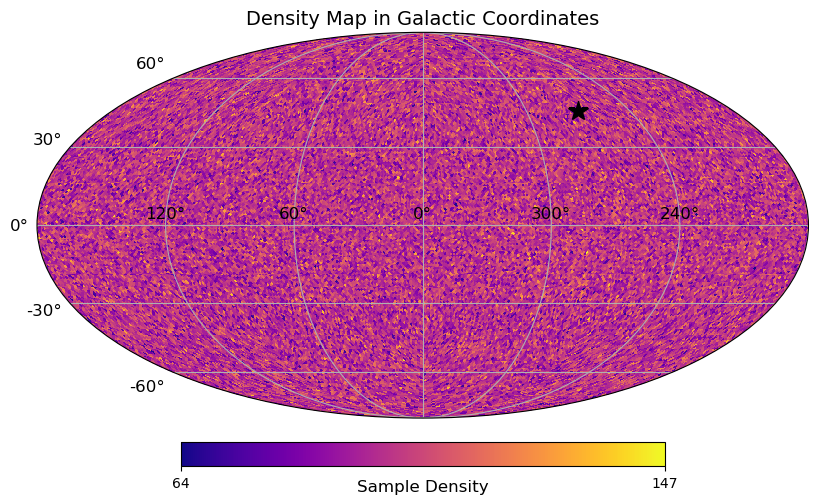

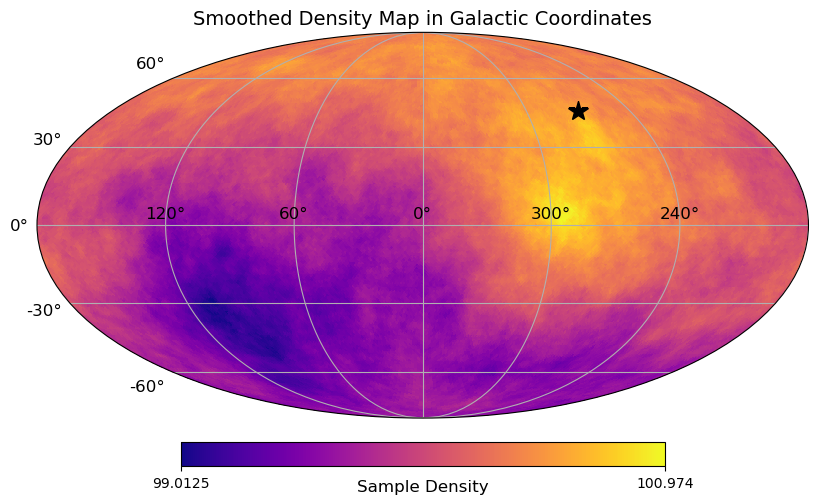

In [22]:
np.random.seed(42)
m, lambda_true_array = poisson_sampling(NSIDE=64,  N_bar=N_bar_true, D=0.007, dipole_theta=np.pi/4, dipole_phi=-np.pi/2)

#Unsmoothed
plotting(m, dipole_theta, dipole_phi,
         title='Density Map in Galactic Coordinates', unit="Sample Density",
        cmap='plasma')

smoothed_map = compute_smooth_map(m, weights=None, angle_scale=1)

plotting(smoothed_map, dipole_theta, dipole_phi,
         title='Smoothed Density Map in Galactic Coordinates', unit="Sample Density",
        cmap='plasma')

In [7]:
param_names = [r'$\bar N$', 'D', r'$\ell$', 'b']
sampler = ultranest.ReactiveNestedSampler(param_names, my_likelihood, my_prior_transform)
result = sampler.run()
sampler.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+05  ..-160364.86 [-160365.0180..-160365.0178]*| it/evals=8915/20802 eff=43.6967% N=400   0  
[ultranest] Likelihood function evaluations: 20807
[ultranest]   logZ = -1.604e+05 +- 0.1669
[ultranest] Effective samples strategy satisfied (ESS = 2206.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.17, need <0.5)
[ultranest]   logZ error budget: single: 0.20 bs:0.17 tail:0.01 total:0.17 required:<0.50
[ultranest] done iterating.

logZ = -160382.649 +- 0.358
  single instance: logZ = -160382.649 +- 0.198
  bootstrapped   : logZ = -160382.647 +- 0.357
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    $\bar N$            : 39.889│ ▁▁▁▁▁▁▁▂▂▂▄▄▅▆▇▇▇▆▇▆▅▅▄▃▂▂▁▁▁▁▁▁▁▁  ▁ │40.123    39.997 +- 0.029
    D                   : 0.0001│ ▁▁ ▁▁▁▁▁▁▁▂▂▃▄▄▅▆▆▇▆▇▅▅▄▄▃▂▂▁▁▁▁▁▁▁ ▁ │0.0113    0.0059 +-

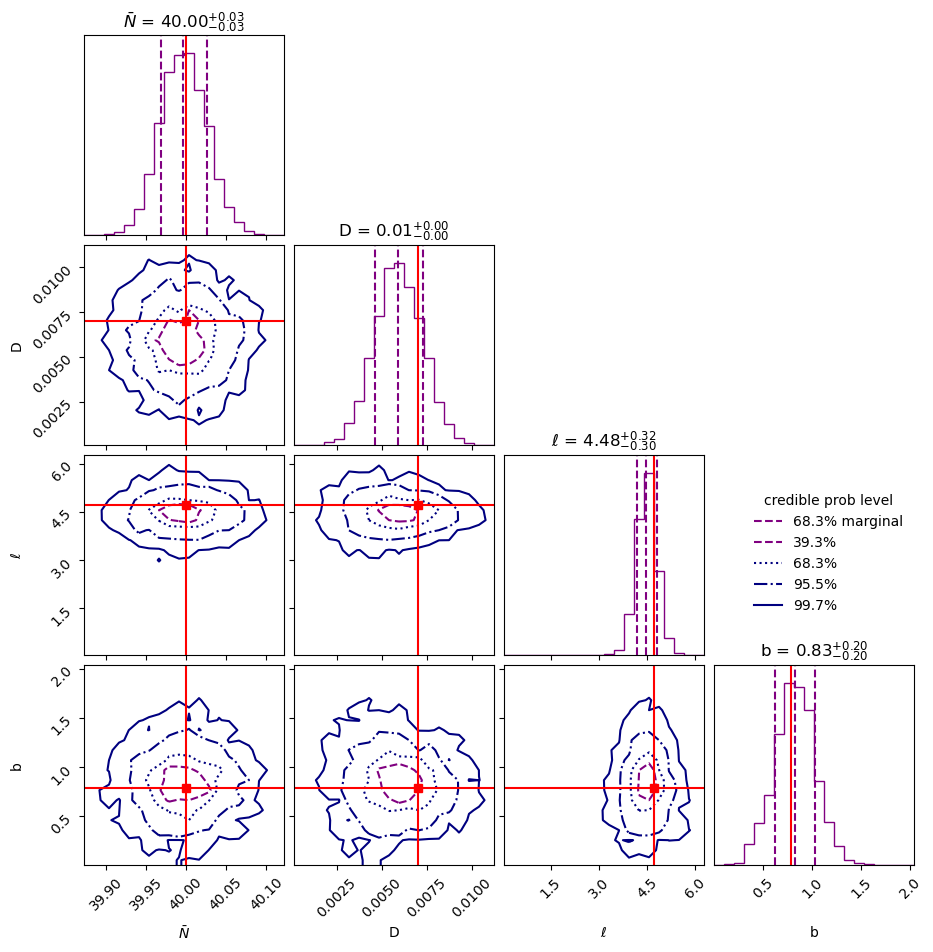

In [8]:
cornerplot(result, truths=[N_bar_true, D_true, -dipole_phi+np.pi, dipole_theta], truth_color='r')
# plt.savefig('../Figures/UN_dipole_cornerplots.png', dpi=300)
plt.show()

In [34]:
result['posterior']['mean'][0]

39.997451867735734

In [9]:
from ultranest.utils import resample_equal
import ultranest.stepsampler

equal_weighted_samples = resample_equal(
    np.array(result['samples']), np.array(result['weighted_samples']['weights'])
)

equal_weighted_samples


array([[4.00039938e+01, 4.65972134e-03, 4.92608234e+00, 9.51847096e-01],
       [3.99660562e+01, 5.50389456e-03, 4.16778564e+00, 1.21625881e+00],
       [4.00345968e+01, 2.42764335e-03, 4.64104153e+00, 7.39727040e-01],
       ...,
       [4.00446873e+01, 4.15095478e-03, 3.74939777e+00, 4.70941943e-01],
       [4.00228530e+01, 4.75515161e-03, 4.71987081e+00, 1.12266315e+00],
       [4.00028679e+01, 5.17439146e-03, 4.44752569e+00, 7.04228284e-01]])

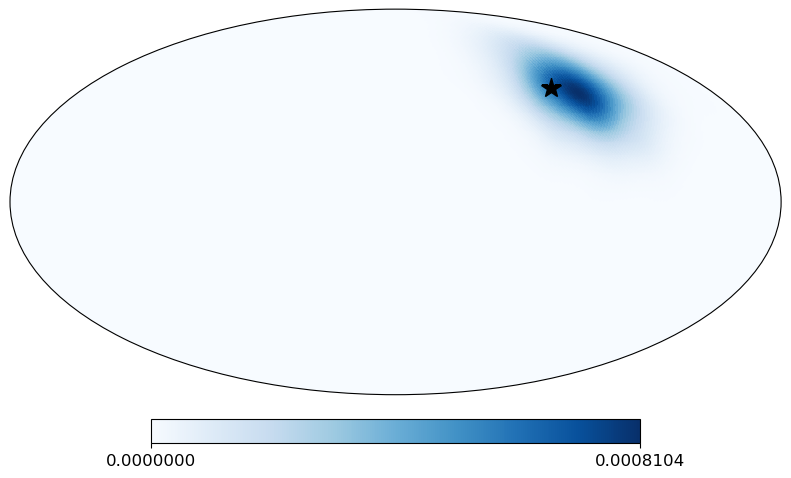

In [10]:
nside = 64  
npix = hp.nside2npix(nside)
healpix_map = np.zeros(npix)

l = equal_weighted_samples[:, 2]  
b = equal_weighted_samples[:, 3]


pixels = hp.ang2pix(nside, b,l, nest=False)

for pix in pixels:
    healpix_map[pix] += 1

smooth = 0.1
healpix_map /= np.sum(healpix_map)
smooth_map = hp.sphtfunc.smoothing(healpix_map, sigma=smooth)
smooth_map[smooth_map < 0] = 0
smooth_map /= np.sum(smooth_map)

hp.projview(smooth_map, cmap="Blues")
newprojplot(theta=dipole_theta, phi=dipole_phi, marker="*", color="k", markersize=15);
# plt.savefig('../Figures/sky_plot.png',dpi=300)

In [11]:
X, Y, proj_map = hp.projview(
    smooth_map, return_only_data=True, xsize=2000
)

In [12]:
def sigma_to_prob2D(sigmas):
    return 1 - np.exp(-0.5 * np.array(sigmas) ** 2)

def compute_2D_contours(P_xy, contour_levels):
    '''
    Compute contour heights corresponding to sigma levels of probability
    density by creating a mapping (interpolation function) from the CDF
    (enclosed prob) to some arbitrary level of probability density.
    from here: https://stackoverflow.com/questions/37890550/python-plotting-percentile-contour-lines-of-a-probability-distribution

    :param P_xy: normalised 2D probability (not density)
    :param contour_levels: pass list of sigmas at which to draw the contours
    :return:
        1. vector of probabilities corresponding to heights at which to
        draw the contours (pass to e.g. plt.contour with levels= kwarg);
        2. uniformly spaced probability levels between 0 and max prob
        3. CDF at given P_level, of length 1000 (the hardcoded number of
            P_levels)
    '''
    P_levels = np.linspace(0, P_xy.max(), 1000)
    mask = (P_xy >= P_levels[:, None, None])
    P_integral = (mask * P_xy).sum(axis=(1,2))
    f = interp1d(P_integral, P_levels)
    t_contours = np.flip(f(sigma_to_prob2D(contour_levels)))
    return t_contours, P_levels, P_integral

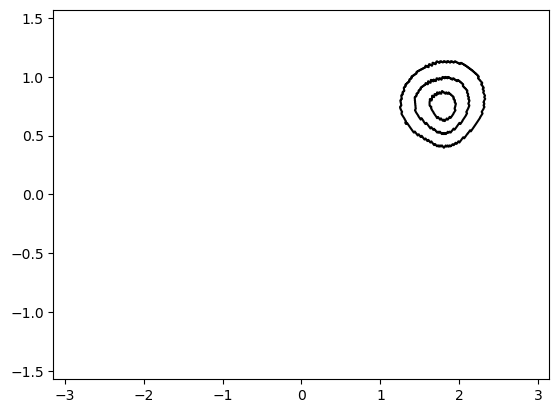

In [13]:
P_xy = proj_map / np.sum(proj_map)

contour_levels = [0.5, 1, 1.5]  

t_contours, P_levels, P_integral = compute_2D_contours(P_xy, contour_levels)

plt.contour(X, Y, P_xy, levels=t_contours, colors='k')

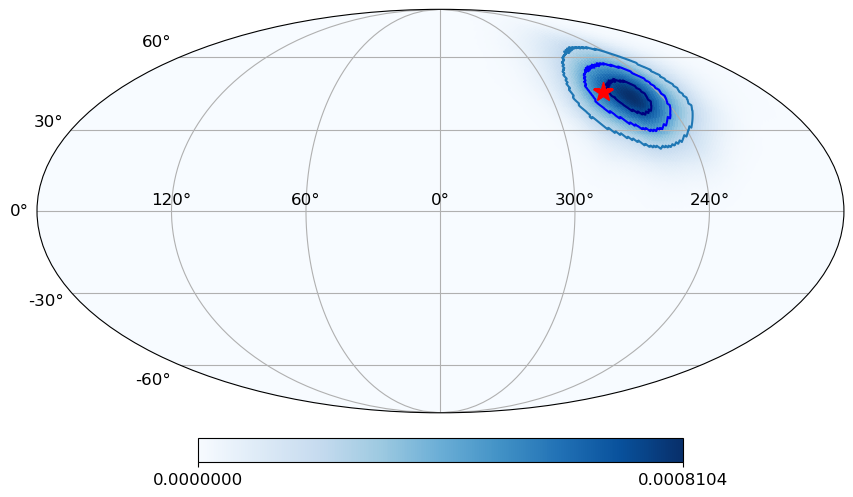

In [14]:
hp.projview(smooth_map, cmap="Blues", graticule=True, graticule_labels=True)
newprojplot(theta=dipole_theta, phi=dipole_phi, marker="*", color="r", markersize=15, zorder=5);

plt.contour(X, Y, P_xy, levels=t_contours, colors=['C0','b','navy'])
# plt.contourf(X, Y, P_xy, levels=t_contours, colors=['C0', 'b', 'navy'], alpha=0.5)
plt.tight_layout()
# plt.savefig('../Figures/dipole_direction_projection.png',dpi=300)
plt.show()

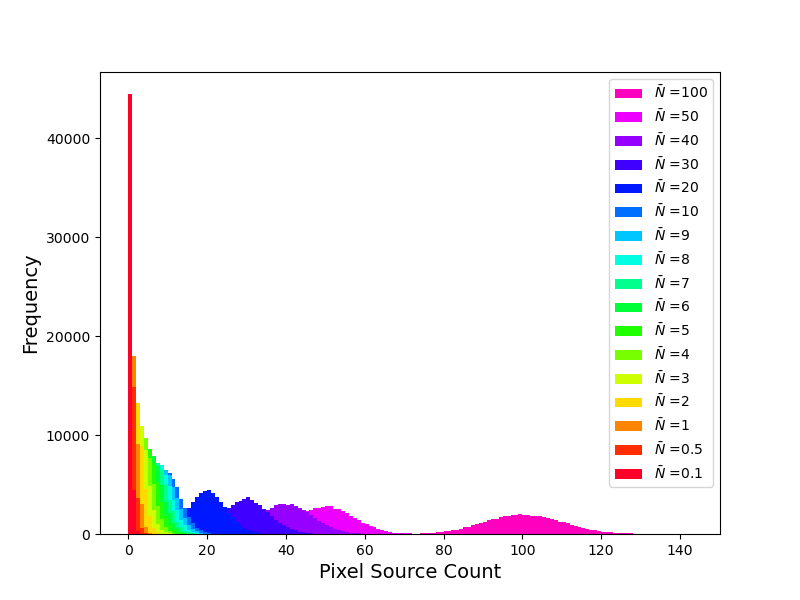

In [157]:
%matplotlib widget

plt.figure(figsize=(8,6))
Nbar_list = [0.1, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,20,30,40,50,100]

cmap = plt.cm.gist_rainbow    # alternative cmap: nipy_spectral

norm = plt.Normalize(vmin=0, vmax=len(Nbar_list)-1)

for idx, N_bar_true in enumerate(reversed(Nbar_list)):
    m, lambda_true_array = poisson_sampling(NSIDE=64, N_bar=N_bar_true,
                                            D=0.007, dipole_theta=np.pi/4, dipole_phi=-np.pi/2)
    
    bins = np.max(m) - np.min(m)
    color = cmap(norm(len(Nbar_list)-1-idx))   # Get a unique color from the colormap for each iteration
    plt.hist(m, bins=bins, alpha=1, color=color, label=fr'$\bar N$ ={N_bar_true}')

plt.legend()
plt.xlabel('Pixel Source Count', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
# plt.xlim(0,130)
plt.ylim(0,None)
plt.show()




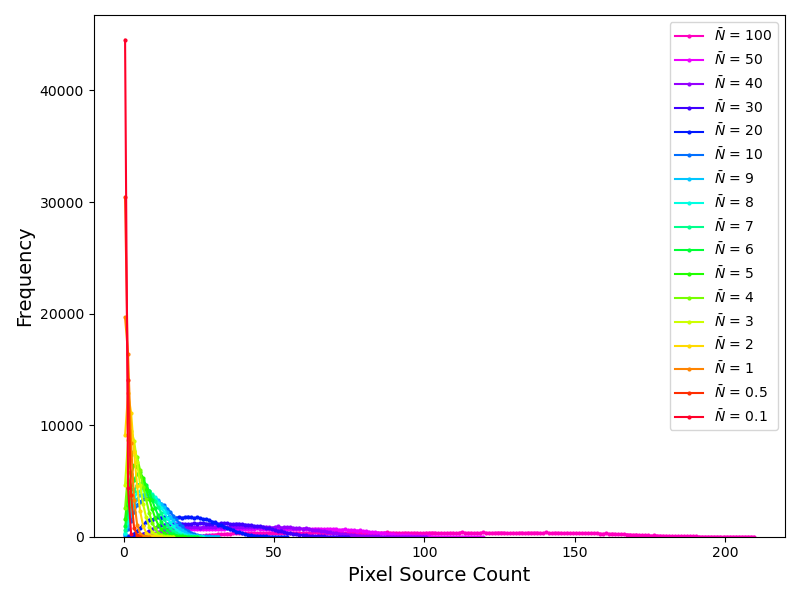

In [150]:
plt.figure(figsize=(8,6))
Nbar_list = [0.1, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 100]

cmap = plt.cm.gist_rainbow    # alternative cmap: nipy_spectral
norm = plt.Normalize(vmin=0, vmax=len(Nbar_list) - 1)

for idx, N_bar_true in enumerate(reversed(Nbar_list)):
    m, lambda_true_array = poisson_sampling(
        NSIDE=64, N_bar=N_bar_true,
        D=0.7, dipole_theta=np.pi/4, dipole_phi=-np.pi/2
    )

    # Histogram values without plotting
    counts, bin_edges = np.histogram(m, bins=int(round((np.max(m) - np.min(m)) / 1)))
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    
    color = cmap(norm(len(Nbar_list) - 1 - idx))
    
    # Plot as scatter points
    plt.plot(bin_centers, counts, marker='o', linestyle='-', color=color, 
             markersize=2, label=fr'$\bar N$ = {N_bar_true}')

plt.legend()
plt.xlabel('Pixel Source Count', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
# plt.xlim(0,130)
plt.ylim(0,None)
plt.tight_layout()
plt.show()
